In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report,roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder

In [2]:
import sys
import os

sys.path.append(os.path.expanduser('~/Documents/Apziva_projects'))
import feature_plots as fp

##Data Exploration

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

In [5]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [24]:
df.age.min()

19

In [6]:
df.y.value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

In [7]:
2792/40000

0.0698

In [8]:
df["default"] = df["default"].map({"yes": 1, "no": 0})
df["housing"] = df["housing"].map({"yes": 1, "no": 0})
df["loan"] = df["loan"].map({"yes": 1, "no": 0})
df["y"] = df["y"].map({"yes": 1, "no": 0})
df['age_log'] = np.log(df['age'] + 1)
df['duration_log'] = np.log(df['duration'] + 1)
df['job_combined'] = ['student_retired' if (x == 'retired')|(x == 'student') else x for x in df['job']]
# Dates
df['month'] = df["month"].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})
# df['month'] = df['month'].str.capitalize()
# df['date'] = pd.to_datetime( '2025-' + df['month'].astype(str) + '-' + df['day'].astype(str), format='%Y-%b-%d',
#                             errors='coerce')
# df['day'] = df['date'].dt.day
# df['month'] = df['date'].dt.month
# def encode(data, col, max_val):
#     data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
#     data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
#     return data
# df = encode(df, 'month', 12)
# df = encode(df, 'day', 31)


In [9]:
## Dropping unkwnowns
df = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]


In [10]:
bins = [-np.inf, 0, np.quantile(df['balance'], 0.25), np.quantile(df['balance'], 0.75), np.quantile(df['balance'], 0.90), np.inf]
labels = ['Neg', 'Low', 'Med', 'High','Very_High']

df['balance_cat'] = pd.cut(df['balance'], bins=bins, labels=labels)

df['balance_cat'].value_counts()


balance_cat
Med          19133
Neg           6671
High          5749
Very_High     3832
Low           2953
Name: count, dtype: int64

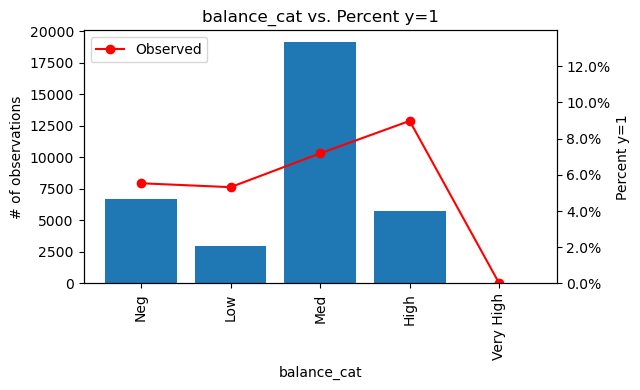

In [11]:
fp.plot_feature_vs_y(df, feature = 'balance_cat',y_col='y', dtype= 'cat', levels = ['Neg', 'Low', 'Med', 'High', 'Very High'], show_boxplot=False)

In [12]:
df[(df['age']> 65) & (df['y'] == 1)]


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,age_log,duration_log,job_combined,balance_cat
29464,68,retired,divorced,primary,0,250,0,0,cellular,3,2,360,1,1,4.234107,5.888878,student_retired,Med
29865,75,retired,divorced,primary,0,3881,1,0,cellular,4,2,136,3,1,4.330733,4.919981,student_retired,Very_High
29961,69,retired,married,primary,0,324,0,0,cellular,4,2,136,4,1,4.248495,4.919981,student_retired,Med
30176,69,management,married,tertiary,0,840,0,0,telephone,5,2,128,3,1,4.248495,4.859812,management,Med
30627,66,technician,married,secondary,0,0,0,0,cellular,6,2,751,1,1,4.204693,6.622736,technician,Neg
30907,66,retired,married,primary,0,206,0,0,cellular,9,2,479,1,1,4.204693,6.173786,student_retired,Med
31032,69,retired,married,primary,0,2346,0,0,cellular,11,2,354,2,1,4.248495,5.872118,student_retired,High
31055,85,retired,married,primary,0,12114,0,0,telephone,12,2,165,2,1,4.454347,5.111988,student_retired,Very_High
31057,72,retired,married,tertiary,0,0,0,0,cellular,13,2,99,1,1,4.290459,4.605170,student_retired,Neg
31069,90,retired,divorced,secondary,0,1,0,0,cellular,13,2,152,3,1,4.510860,5.030438,student_retired,Low


In [ ]:
df["age_binned"] = pd.cut(
    df["age"],
    bins=[19, 25, 35, 45, 55, np.inf],
    labels=["19-25", "26-35", "36-45", "46-55", "56+"],
    right=True,  
)

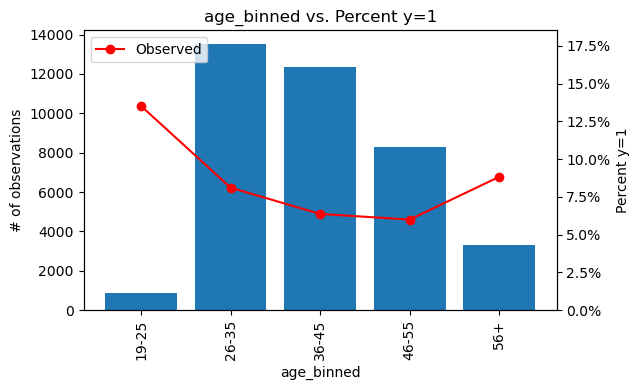

In [32]:
fp.plot_feature_vs_y(df, feature = 'age_binned',y_col='y', dtype= 'cat', levels = [ "19-25", "26-35", "36-45", "46-55", "56+"], show_boxplot=False)

/var/folders/4l/s81p4w090kx1p7r6kb_bznjm0000gn/T/ipykernel_9592/2590238381.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["age_binned_combined"] = df["age_binned"].replace({


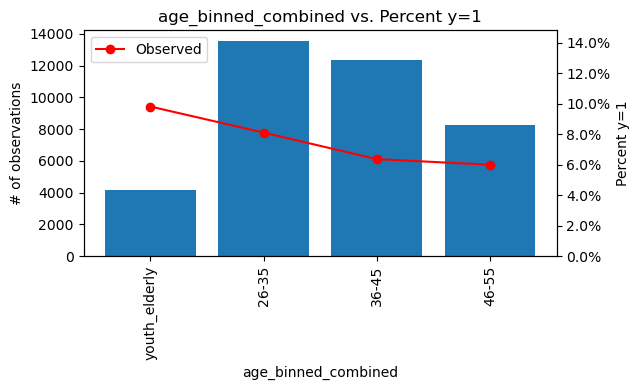

In [33]:
df["age_binned_combined"] = df["age_binned"].replace({
    "19-25": "youth_elderly", 
    "56+": "youth_elderly"
})
fp.plot_feature_vs_y(df, feature = 'age_binned_combined',y_col='y', dtype= 'cat', levels = [ "youth_elderly", "26-35", "36-45", "46-55"], show_boxplot=False)

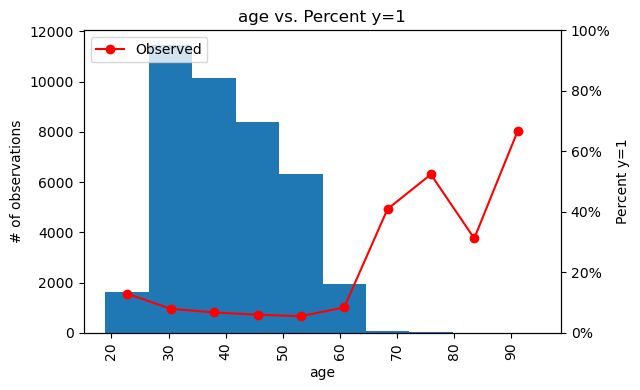

In [9]:
fp.plot_feature_vs_y(df, feature = 'age',y_col='y', dtype= 'quant', show_boxplot=False, n_bins= 10, bin_method="cut")

In [ ]:
#Check to ensure the values make sense
#Remove outliers by variable instead of general sweep
#Only remove outliers in training data

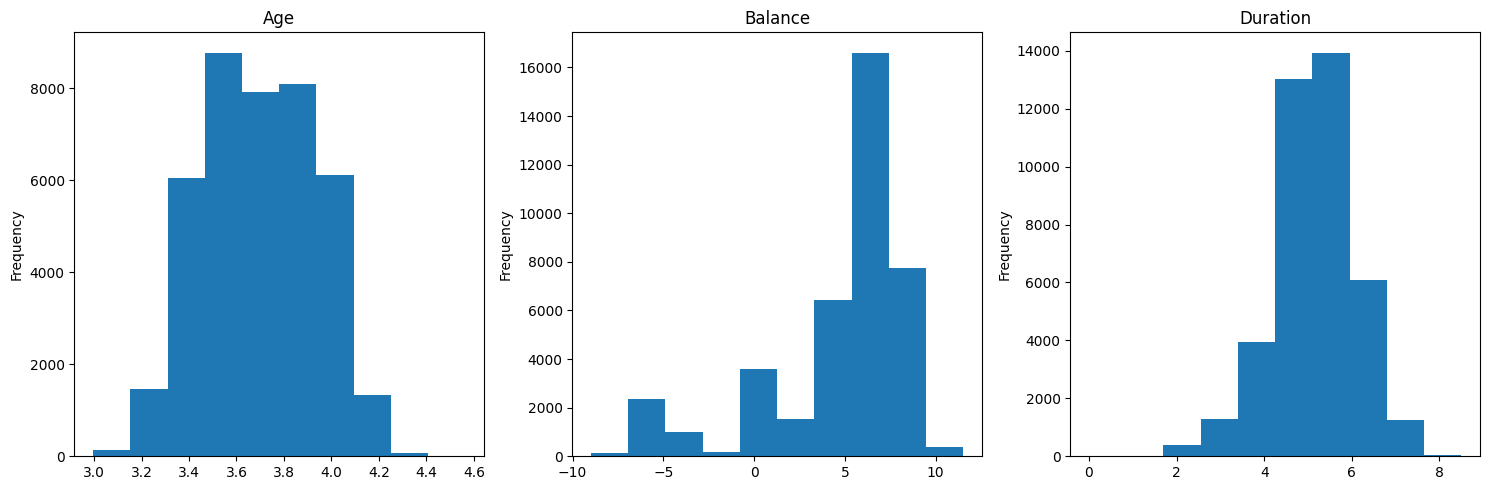

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age_log.plot.hist(ax=axes[0], title="Age")
df.balance_log.plot.hist(ax=axes[1], title="Balance")
df.duration_log.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

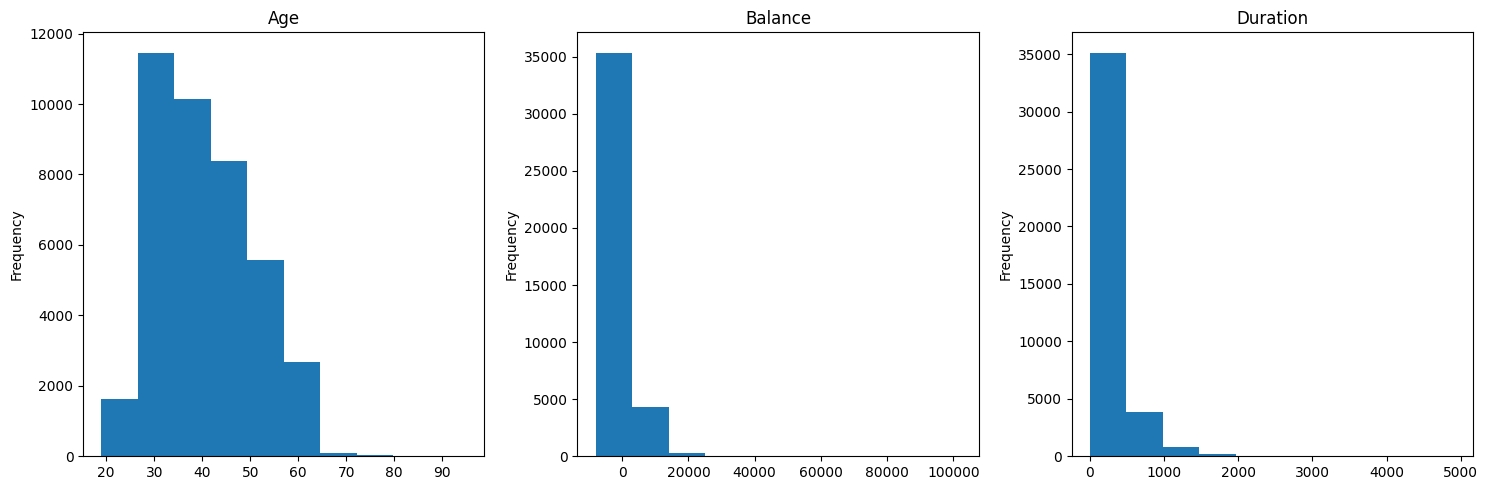

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age.plot.hist(ax=axes[0], title="Age")
df.balance.plot.hist(ax=axes[1], title="Balance")
df.duration.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

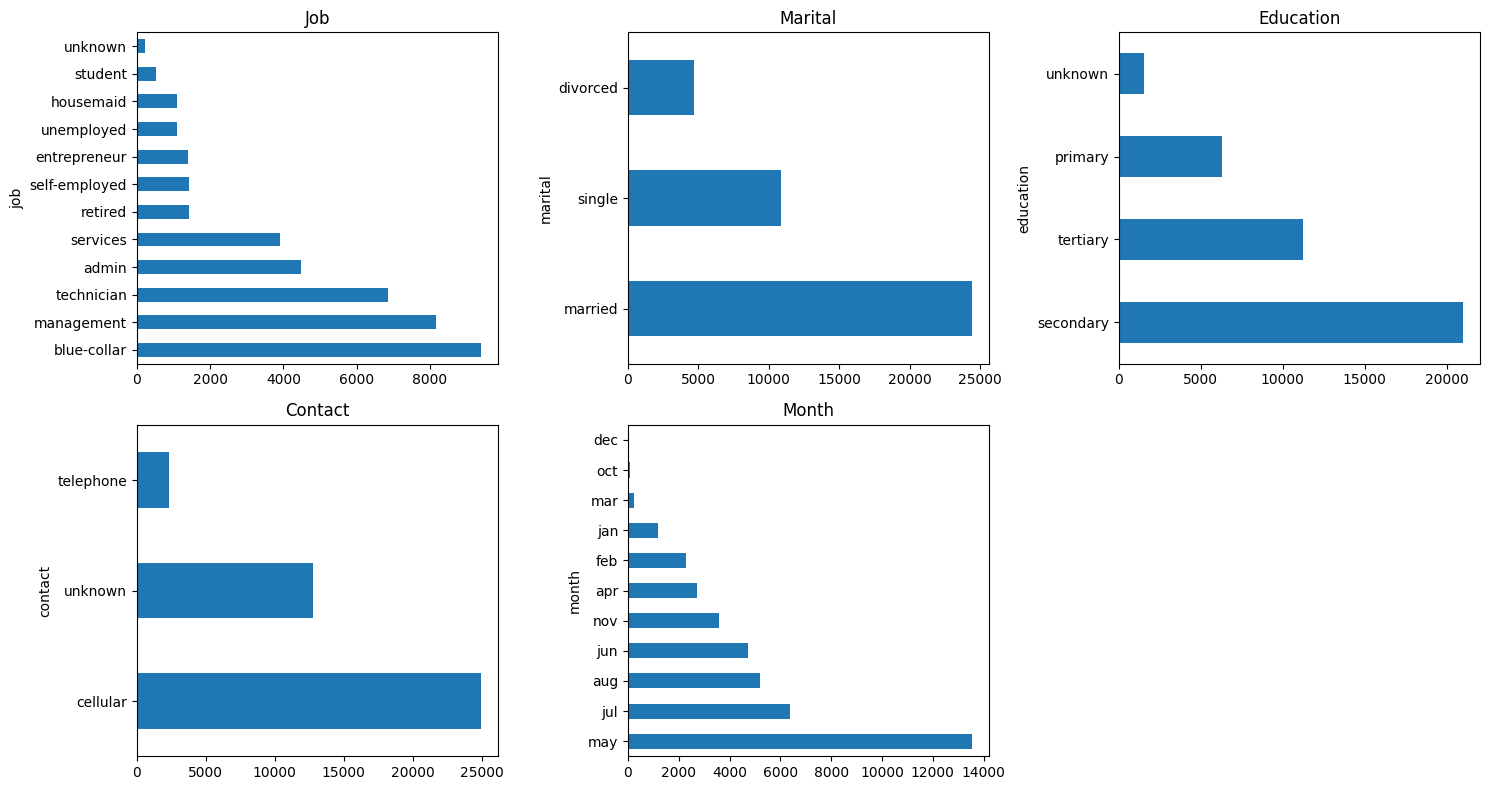

In [ ]:
# Make a grid of 2 rows × 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

df.job.value_counts().plot.barh(ax=axes[0], title="Job")
df.marital.value_counts().plot.barh(ax=axes[1], title="Marital")
df.education.value_counts().plot.barh(ax=axes[2], title="Education")
df.contact.value_counts().plot.barh(ax=axes[3], title="Contact")
df.month.value_counts().plot.barh(ax=axes[4], title="Month")

# Hide the unused subplot (6th slot)
axes[5].axis("off")

plt.tight_layout()
plt.show()

###Explore Variable relationships with Y

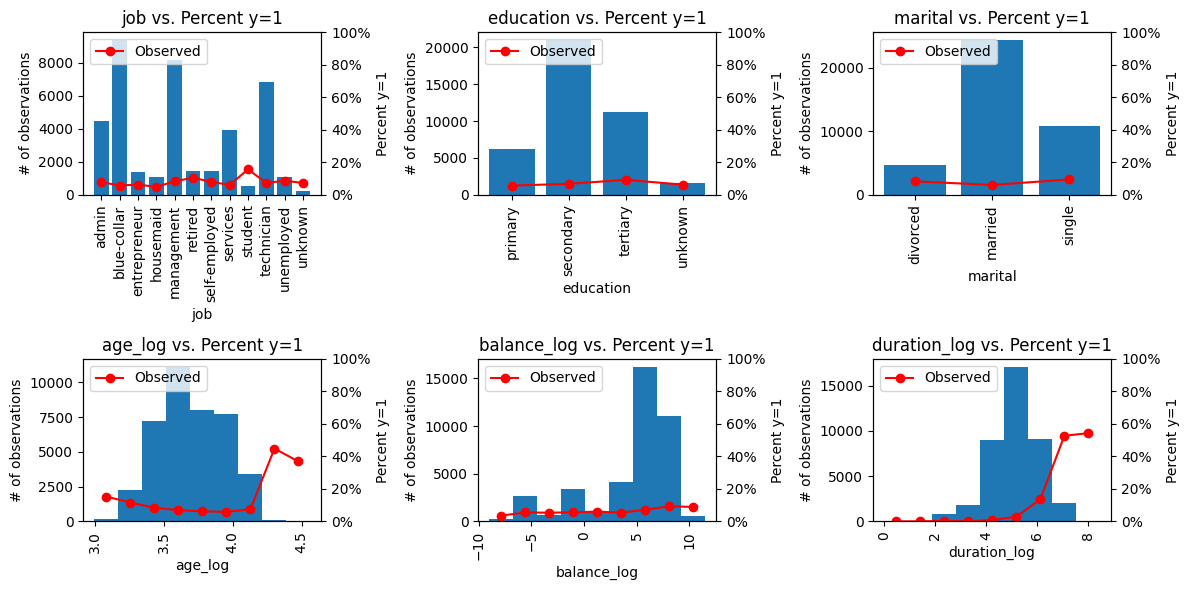

In [7]:
# Grid of many features
fp.plot_features_vs_y_grid(
    df, ["job","education","marital","age_log","balance_log","duration_log"],
    y_col="y",
    dtype={"job":"cat","education":"cat","marital":"cat","age_log":"quant","balance_log":"quant","duration_log":"quant"},
    n_bins=9, cols=3, bin_method = "cut"
)


##Model

**Data_split**

In [13]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y',
       'age_log', 'duration_log', 'job_combined', 'balance_cat'],
      dtype='object')

In [34]:
y = df["y"]
X = df.drop(columns=["y", "age", "balance", "duration","job","age_binned"])
X.sample(15)

,marital,education,default,housing,loan,contact,day,month,campaign,age_log,duration_log,job_combined,balance_cat,age_binned_combined
26212,married,primary,0,1,0,cellular,20,11,1,3.912023,4.948760,blue-collar,Very_High,46-55
34603,single,tertiary,0,1,1,cellular,5,5,1,3.496508,5.991465,management,Low,26-35
35570,married,tertiary,0,1,1,cellular,7,5,6,3.433987,5.545177,management,Med,26-35
16638,single,secondary,0,0,1,cellular,24,7,1,3.433987,5.135798,unemployed,Med,26-35
24617,married,secondary,0,0,0,telephone,17,11,3,3.912023,5.676754,admin,Med,46-55
1233,married,primary,0,1,0,unknown,8,5,1,4.127134,5.323010,blue-collar,Med,youth_elderly
34201,married,tertiary,0,0,0,cellular,4,5,1,3.850148,5.886104,management,High,46-55
4367,married,primary,0,1,0,unknown,19,5,2,3.970292,5.700444,blue-collar,Med,46-55
36149,married,secondary,0,1,0,cellular,11,5,2,3.806662,6.156979,management,Very_High,36-45
8285,divorced,secondary,0,1,0,unknown,2,6,2,3.496508,6.616065,blue-collar,Neg,26-35


In [37]:
#Preprocessing Data
cat = ["job_combined","education","marital","contact","balance_cat","age_binned_combined"]
#OneHot Encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(
    [('one_hot', OneHotEncoder(dtype='float'), cat)],
    remainder='passthrough', verbose_feature_names_out=False)

X_hot_encode = ct.fit_transform(X)
hot_encode_names = ct.get_feature_names_out().tolist()
hot_encode_names

['job_combined_admin',
 'job_combined_blue-collar',
 'job_combined_entrepreneur',
 'job_combined_housemaid',
 'job_combined_management',
 'job_combined_self-employed',
 'job_combined_services',
 'job_combined_student_retired',
 'job_combined_technician',
 'job_combined_unemployed',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'balance_cat_High',
 'balance_cat_Low',
 'balance_cat_Med',
 'balance_cat_Neg',
 'balance_cat_Very_High',
 'age_binned_combined_26-35',
 'age_binned_combined_36-45',
 'age_binned_combined_46-55',
 'age_binned_combined_youth_elderly',
 'age_binned_combined_nan',
 'default',
 'housing',
 'loan',
 'day',
 'month',
 'campaign',
 'age_log',
 'duration_log']

In [39]:
X_train, X_tv, y_train, y_tv = train_test_split(X_hot_encode, y, test_size=0.20, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_tv, y_tv, test_size=0.50, random_state=42)


In [38]:
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
# define model
model = XGBClassifier(learning_rate=.1, objective='binary:logistic',max_delta_step=1)

# define grid
weights = [1, 12.6, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_hot_encode, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.951647 using {'scale_pos_weight': 1}
0.951647 (0.003451) with: {'scale_pos_weight': 1}
0.949228 (0.003243) with: {'scale_pos_weight': 12.6}
0.947830 (0.003411) with: {'scale_pos_weight': 25}
0.946898 (0.003430) with: {'scale_pos_weight': 50}
0.946143 (0.003580) with: {'scale_pos_weight': 75}
0.945962 (0.003665) with: {'scale_pos_weight': 99}
0.946009 (0.004002) with: {'scale_pos_weight': 100}
0.943411 (0.004264) with: {'scale_pos_weight': 1000}


In [44]:
# create model instance
#n_estimators=1000, max_depth=5, learning_rate=.1, objective='binary:logistic',
model = XGBClassifier(learning_rate=.1, objective='binary:logistic',gamma = 1,max_delta_step=1)
# fit model
model.fit(X_train, y_train)
# make predictions
y_pred_train = model.predict(X_train)
y_preds_test = model.predict(X_test)

In [45]:
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_preds_test))

Train Metrics
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28415
           1       0.75      0.50      0.60      2255

    accuracy                           0.95     30670
   macro avg       0.86      0.74      0.79     30670
weighted avg       0.95      0.95      0.95     30670

Test Metrics
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3561
           1       0.64      0.42      0.50       273

    accuracy                           0.94      3834
   macro avg       0.80      0.70      0.74      3834
weighted avg       0.93      0.94      0.94      3834



Train
Test


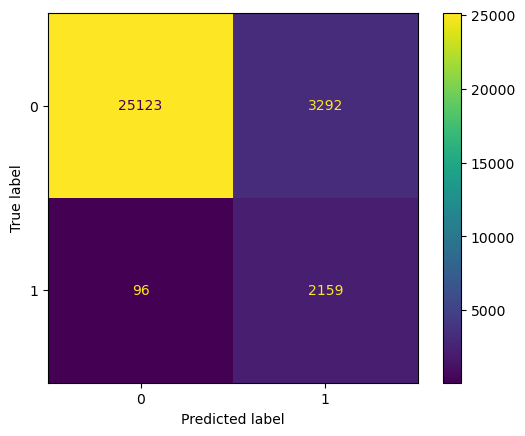

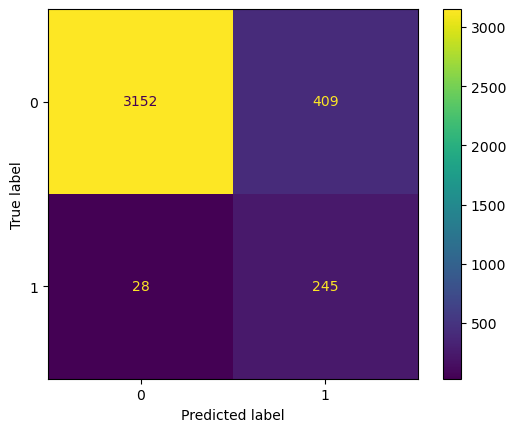

In [96]:
print("Train")
cm_train = confusion_matrix(y_train, y_pred_train, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=bst.classes_)
disp.plot()
print("Test")
cm_test = confusion_matrix(y_test, y_preds_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=bst.classes_)
disp_test.plot()
plt.show()

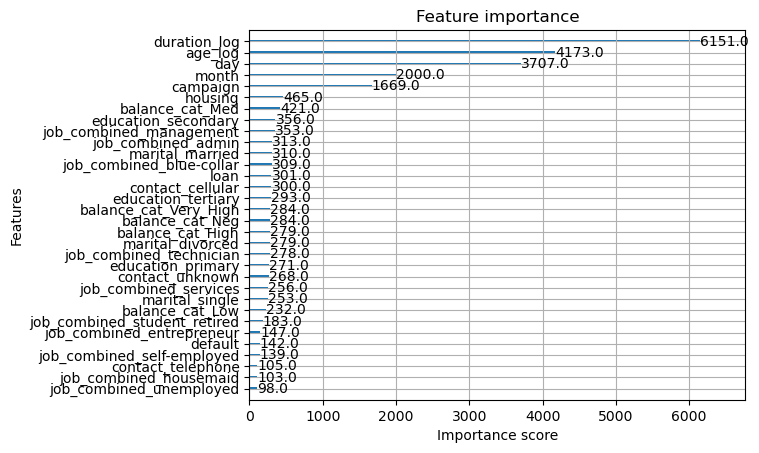

In [97]:
#AUC/ROC
#Predicted vs. Observed
bst.get_booster().feature_names = hot_encode_names
plot_importance(bst.get_booster())
plt.show()

In [14]:
import shap
X_test = pd.DataFrame(X_test, columns=hot_encode_names)
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)
shap.initjs()

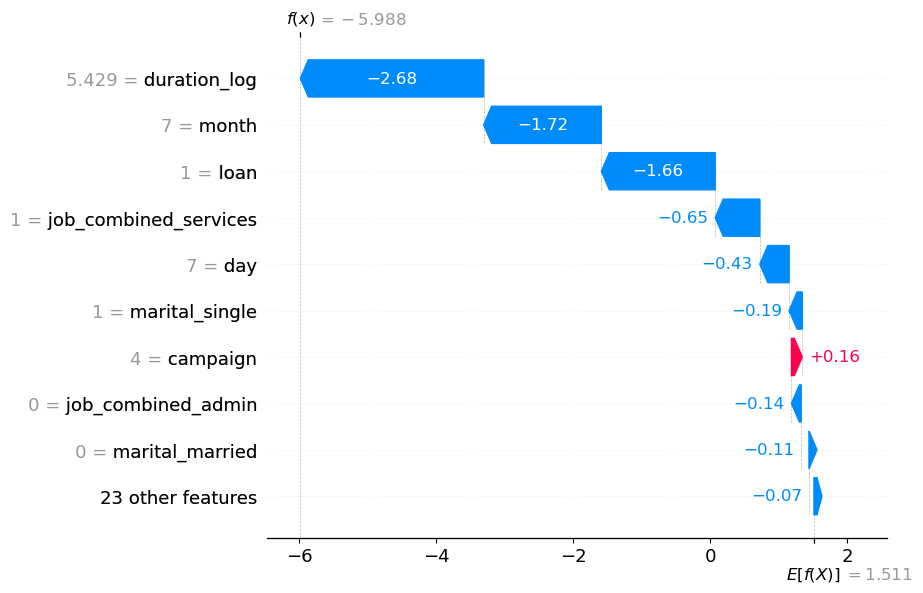

In [15]:
import matplotlib.pyplot as plt

shap.waterfall_plot(shap_values[0]) 
# plt.savefig("YyqSMCLaRZesyT0w/waterfall_plot.png", bbox_inches="tight", dpi=300)
# plt.close()  # optional, so figures don’t pile up in memory


In [ ]:
n_bins = 8
AVG_bin = pd.qcut(df['AVG'], q=n_bins, duplicates='drop')

agg = (df
       .groupby(AVG_bin, observed=True)
       .agg(count=('y','size'), prop_y1=('y','mean'),
            x_mid=('AVG', 'median'))
       .reset_index())

# Plot
fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=(10,4), gridspec_kw={'width_ratios':[2,1]})

# Left plot: counts + proportion
ax_left.bar(agg['x_mid'], agg['count'],
            width=np.diff(np.r_[agg['x_mid'], agg['x_mid'].iloc[-1]]).mean())
ax_left.set_xlabel('AVG (binned, midpoint)')
ax_left.set_ylabel('# of observations')

ax2 = ax_left.twinx()
ax2.plot(agg['x_mid'], agg['prop_y1'], marker='o', color='red')
ax2.set_ylabel('P(Y=1)')
ax2.set_ylim(0,1)
ax_left.set_title('P(Y=1) vs AVG (binned)')

# Right plot: boxplot
sns.boxplot(x='Y', y='AVG', data=df, ax=ax_right)
ax_right.set_title('Distribution of AVG by Y')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_feature_vs_happiness(df,feature,y_col="y", y_pred_col=None,
                              levels=(1, 2, 3, 4, 5),
                              show_boxplot=True,figsize=(10, 4)):
    from matplotlib.ticker import PercentFormatter
    # counts and means (fill missing categories with 0)
    counts = df[feature].value_counts().reindex(levels, fill_value=0)
    obs = df.groupby(feature)[y_col].mean().reindex(levels, fill_value=0.0)

    pred = None
    if y_pred_col and y_pred_col in df.columns:
        pred = df.groupby(feature)[y_pred_col].mean().reindex(levels, fill_value=0.0)

    # figure / axes
    if show_boxplot:
        fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=figsize)
    else:
        fig, ax_left = plt.subplots(figsize=(figsize[0]*0.65, figsize[1]))
        ax_right = None

    # LEFT: bars + one twin axis for both lines
    ax_left.bar(counts.index, counts.values)
    ax_left.set_xlabel(feature)
    ax_left.set_ylabel('# of observations')
    ax_left.set_title(f'{feature} vs. customer satisfaction')

    ax_line = ax_left.twinx()
    ax_line.set_ylabel('Percent Happy')
    ax_line.set_ylim(0, 1)
    ax_line.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    # plot observed (+ optional predicted) with a tiny loop
    handles = []
    for series, label, color in [(obs, 'Observed', 'red'), (pred, 'Predicted', 'yellow')]:
        if series is None:
            continue
        (ln,) = ax_line.plot(series.index, series.values, marker='o', label=label, color=color)
        handles.append(ln)

    if handles:
        ax_line.legend(handles=handles, loc='upper left')

    # RIGHT: optional boxplot
    if show_boxplot:
        sns.boxplot(x=y_col, y=feature, data=df, ax=ax_right)
        ax_right.set_title(f'Distribution of {feature} by {y_col}')
        ax_right.set_xlabel(f'{y_col} (0: Unhappy, 1: Happy)')

    plt.tight_layout()
    return fig, (ax_left, ax_right)
